## Imports & Data loading

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

False

In [3]:
cd ..

c:\Users\sachi\SensoriumDecoding


In [4]:
from src.utils.data import load_args
from src.utils.data import get_training_ds
from src.utils.data import get_datasets

In [5]:
class Args:
    def __init__(self):
        self.device = torch.device("cpu")
        self.output_dir = "runs"

args = Args()
load_args(args)

In [6]:
train_ds, val_ds, test_ds = get_training_ds(
    args,
    data_dir=args.dataset,
    mouse_ids=args.mouse_ids,
    batch_size=args.batch_size,
    device=args.device,
)

In [8]:
train_ds['D'].__getitem__(0)['response'].shape

AttributeError: 'DataLoader' object has no attribute '__getitem__'

In [ ]:
for batch in val_ds['S1']:
    print(batch)

In [18]:
batch['response'].shape

torch.Size([1, 7538])

In [9]:
train_ds, val_ds, test_ds = get_datasets(
    args,
    data_dir=args.dataset,
    mouse_ids=args.mouse_ids,
)

## Sample data

In [ ]:
mouseA_trial0 = train_ds['A'].__getitem__(0)
output_size = 36864
mouseA_trial0['image'].flatten().shape

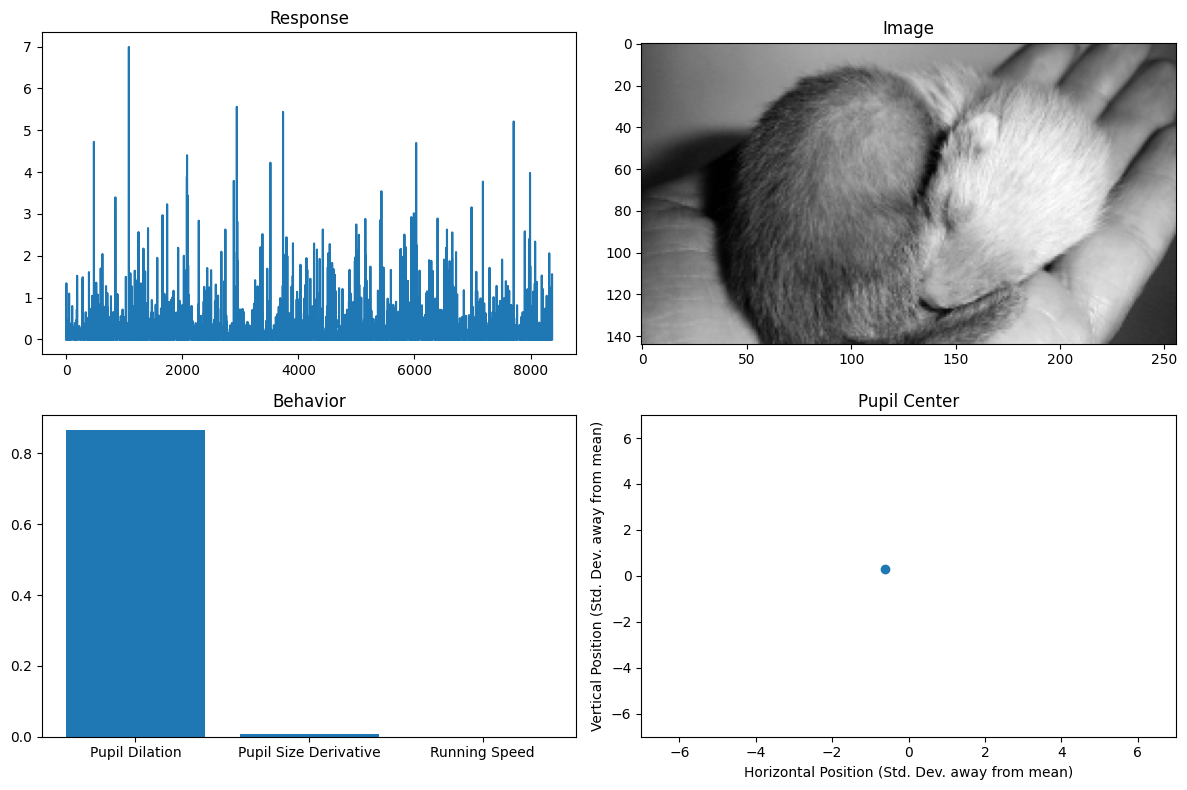

In [34]:
# Figure, axes for response, image, behavior, pupil center
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Plot response
ax[0, 0].plot(mouseA_trial0['response'])
ax[0, 0].set_title('Response')

# Plot image
ax[0, 1].imshow(np.squeeze(mouseA_trial0['image']), cmap='gray')
ax[0, 1].set_title('Image')

# Plot behavior
behavior_labels = ['Pupil Dilation', 'Pupil Size Derivative', 'Running Speed']
ax[1, 0].bar(behavior_labels, mouseA_trial0['behavior'])
ax[1, 0].set_title('Behavior')

# Plot pupil center
pupil_center = mouseA_trial0['pupil_center']
ax[1, 1].scatter(pupil_center[0], pupil_center[1])
ax[1, 1].set_title('Pupil Center')
ax[1, 1].set_xlabel('Horizontal Position (Std. Dev. away from mean)')
ax[1, 1].set_ylabel('Vertical Position (Std. Dev. away from mean)')
ax[1, 1].set_xlim([-7, 7])
ax[1, 1].set_ylim([-7, 7])

plt.tight_layout()
plt.show()

## Linear model example

In [7]:
from sklearn.linear_model import Ridge
#from sklearn.metrics import root_mean_squared_error

In [8]:
ridge_model = Ridge(alpha=1.0)

In [14]:
for batch in val_ds['S1']:
    print(batch)

In [12]:
# Training data
for mouse in ['S1']:#, 'A', 'B', 'C', 'D', 'E']:
    for i, batch in enumerate(train_ds[mouse]):
        print(f'Batch {i} of {len(train_ds[mouse])}')
        X_train_batch = (sample.flatten().numpy() for sample in batch['response']).numpy()
        y_train_batch = (image.flatten().numpy() for image in batch['image']).numpy()    
        ridge_model.fit(X_train_batch.numpy(), y_train_batch.numpy())

# Testing data
y_test, y_pred = [], []

for mouse in ['S1']:#, 'A', 'B', 'C', 'D', 'E']:
    for batch in test_ds[mouse]:
        X_test_batch = (sample.flatten().numpy() for sample in batch['response']).numpy()
        y_test_batch = (image.flatten().numpy() for image in batch['image']).numpy()
        y_pred_batch = ridge_model.predict(X_test_batch)
        y_test.extend(y_test_batch)
        y_pred.extend(y_pred_batch)

In [ ]:
test_loss = root_mean_squared_error(y_test.numpy(), y_pred.numpy())
test_corr = np.corrcoef(y_test.numpy(), y_pred.numpy())
print(f'Test RMSE: {test_loss}')
print(f'Test Correlation: {test_corr}')